In [1]:
# Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm

%matplotlib inline

## Data engineering

In [2]:
# let's import the vst-transformed count matrix (rows = samples, col = genes; last col = label)
lusc_data = pd.read_csv("./datasets/LUSC_geneReadCount_VST.csv")

In [3]:
lusc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551 entries, TCGA-94-7943-01A-11R-2187-07 to TCGA-51-4079-01A-01R-1100-07
Columns: 39753 entries, ENSG00000000003 to label
dtypes: float64(39752), object(1)
memory usage: 167.1+ MB


In [4]:
lusc_data.head(n = 2)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920,label
TCGA-94-7943-01A-11R-2187-07,12.598295,3.347690,11.399091,9.710489,9.840727,9.545426,10.041732,12.644989,14.885584,11.249983,...,3.815171,2.867519,4.105474,6.292337,4.185603,2.867519,2.867519,5.871927,3.815171,TP
TCGA-68-8251-01A-11R-2296-07,11.612011,2.867519,10.177441,9.713037,10.129734,9.244418,11.915565,11.611566,11.623539,11.601289,...,3.601768,2.867519,3.762122,5.592759,4.582716,2.867519,3.601768,5.733117,3.601768,TP


In [5]:
lusc_data.describe()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281849,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,...,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,11.506768,3.210376,11.134674,9.733453,9.366600,9.736418,11.722034,11.641264,12.855367,11.043012,...,4.041995,4.042448,3.120010,3.606434,5.596421,4.555536,2.958657,3.082710,6.137523,4.073239
std,0.787590,0.489220,0.571272,0.434617,0.852139,1.322106,1.258561,0.614512,1.675005,0.487124,...,0.453254,0.880900,0.491202,0.442423,0.718426,0.651652,0.251155,0.318855,0.801420,0.684128
min,7.633507,2.867519,9.681449,8.687156,6.778143,6.532816,7.149722,9.207351,7.908137,9.835914,...,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,4.286747,2.867519
25%,11.028481,2.867519,10.740382,9.414906,8.960434,8.812821,10.870713,11.260034,11.560327,10.676899,...,3.767203,3.494788,2.867519,3.377046,5.174235,4.145110,2.867519,2.867519,5.601021,3.640888
50%,11.528563,2.867519,11.121858,9.711340,9.450394,9.633702,11.892007,11.657195,12.795053,11.006232,...,4.053541,3.864506,2.867519,3.636971,5.694652,4.508810,2.867519,2.867519,6.058458,3.970914
75%,11.998324,3.480934,11.516073,9.988039,9.921684,10.525566,12.618282,12.009649,14.104870,11.355443,...,4.298340,4.426093,3.352355,3.874470,6.071015,4.917957,2.867519,3.383177,6.563879,4.382519
max,15.404360,7.775136,13.403787,11.144561,11.439552,13.296483,14.531509,13.998175,17.055902,12.420048,...,5.662153,7.031399,6.139507,4.837585,7.661138,8.614201,5.295860,4.613722,9.488109,7.189747


In [6]:
# let's encode the labels
lusc_data = lusc_data.replace("NT", 0) # NT (nromal tissue) as 0
lusc_data = lusc_data.replace("TP", 1) # TP (primary tumour) as 1

In [7]:
# let's check the count of each label type
print(lusc_data["label"].value_counts())

1    502
0     49
Name: label, dtype: int64


In [8]:
# let's construct the target vector
labels = np.array(lusc_data['label'])
labels.shape

(551,)

In [9]:
# let's construct the feature matrix (by dropping the label column)
features = lusc_data.drop('label', axis = 1)
features.shape

(551, 39752)

In [10]:
# let's check if we have any missing variables
features.isnull().sum().unique()

array([0])

In [11]:
# let's import the list of features (genes) along with the differential testing statitsics
geneStats = pd.read_csv("./datasets/geneStats.csv", header = 0)
print(geneStats.shape)
geneStats.head()

(39610, 8)


,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82


In [12]:
# let's filter the genes by signficancy (padj <= 0.01) and sort by log2FC
ranked_genes = geneStats[geneStats['padj'] <= 0.01].sort_values(by = 'log2FoldChange', ascending = False, key = abs)
ranked_genes.head()

,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82


In [13]:
# let's take the top n genes as features 
ranked_genes10   = ranked_genes.iloc[:10,:2]
ranked_genes20   = ranked_genes.iloc[:20,:2]
ranked_genes40   = ranked_genes.iloc[:40,:2]
ranked_genes100  = ranked_genes.iloc[:100,:2]
ranked_genes1000 = ranked_genes.iloc[:1000,:2]

In [14]:
ranked_genes.iloc[:40,:]

,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82
5,ENSG00000128714,HOXD13,377.0,9.545,0.441,21.620,1.160000e-103,1.230000e-101
6,ENSG00000236956,NF1P8,25.4,9.532,0.737,12.935,2.860000e-38,3.980000e-37
7,ENSG00000132446,FTHL17,20.4,9.507,0.985,9.653,4.770000e-22,3.110000e-21
8,ENSG00000123584,MAGEA9,33.9,9.498,0.738,12.864,7.140000e-38,9.780000e-37
9,ENSG00000170516,COX7B2,31.1,9.469,0.821,11.534,8.890000e-31,8.860000e-30


In [15]:
# let's subset the feature matrix to keep only top 40 ranked genes
features_genes40 = features.filter(ranked_genes40['ensembl_gene_id'])
# rename columns: Ensembl Ids -> RefSeq Ids
features_genes40.rename(columns = dict(zip(ranked_genes40['ensembl_gene_id'], ranked_genes40['hgnc_symbol'])), inplace= True)
features_genes40.head()

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
TCGA-94-7943-01A-11R-2187-07,2.867519,2.867519,3.347690,3.815171,5.329022,5.234964,2.867519,2.867519,2.867519,2.867519,...,3.347690,4.018372,6.828737,4.329596,3.347690,12.297560,3.815171,4.772655,4.571647,3.815171
TCGA-68-8251-01A-11R-2296-07,4.207374,2.867519,2.867519,3.895277,4.293196,10.343212,2.867519,10.073947,8.921288,2.867519,...,3.601768,5.221602,9.593678,6.725751,3.895277,4.965361,5.562891,6.165918,5.678669,5.297088
TCGA-33-A5GW-01A-11R-A27Q-07,3.439060,2.867519,4.326600,12.353466,10.270707,7.112492,2.867519,3.670685,2.867519,3.439060,...,2.867519,11.566494,14.448280,4.795128,5.134576,9.246744,7.917821,5.965390,7.075626,8.578642
TCGA-85-8070-01A-11R-2247-07,2.867519,3.504046,2.867519,11.993517,12.313800,6.674558,7.348623,3.504046,7.050849,6.653913,...,3.504046,10.227045,9.181157,4.672567,11.780299,12.582205,8.601480,6.500372,2.867519,7.018981
TCGA-85-8479-01A-11R-2326-07,3.422884,2.867519,2.867519,2.867519,3.422884,6.354543,2.867519,2.867519,2.867519,2.867519,...,3.422884,3.648222,13.844222,4.287902,2.867519,3.422884,3.422884,3.648222,5.926021,4.461587


In [16]:
# let's split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_genes40, labels, test_size = 0.20, random_state = 44)

In [17]:
# let's check the shape of each set
(X_train.shape,
 y_train.shape,
 X_test.shape,
 y_test.shape)

((440, 40), (440,), (111, 40), (111,))

Variables measured at differnet scales do not contribute equally to model fitting and might introduce a bias. One way to deal with it is feature-wise standarisation, i.e. mean = 0, and SD = 1 prior to model fitting.
To avoid data leakage from the test set into the training set, I will normalise the training set only and then use the normaliation facotrs, calculated on the training set, to normalise the the testing set.

In [18]:
# let's use `StandardScaler()` to z-score normalise each feature (column) individually.
std_scaler = StandardScaler()
std_X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns = X_train.columns)
std_X_train

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
0,3.031160,-0.392266,-0.449116,-0.278537,-0.805106,-0.876975,0.005884,-0.37932,-0.583953,0.068371,...,-0.072238,-0.014003,0.206964,-0.621494,-0.765977,-0.651073,1.148725,0.522164,0.600571,1.090834
1,-0.274231,1.105218,-0.449116,0.395981,0.751573,0.671920,-0.616215,-0.37932,-0.583953,-0.547127,...,-0.273524,-0.279329,0.375350,1.138250,-0.256209,0.029665,0.586479,0.121547,0.748555,0.667291
2,-0.680008,-0.392266,-0.449116,-1.085926,-1.120440,1.304060,-0.616215,-0.37932,-0.111951,-0.547127,...,-0.088737,-0.947724,-0.845697,0.226354,-0.765977,-0.118823,1.380099,-0.808125,-1.508507,-0.403683
3,-0.508040,-0.392266,-0.449116,-0.849726,-0.884586,1.241082,1.674590,-0.37932,2.084130,-0.338818,...,-0.101468,-0.538452,1.118164,1.018291,-0.511088,-0.652781,1.454953,1.420941,0.732059,0.104736
4,-0.300329,-0.392266,-0.079630,-1.085926,-1.120440,0.216082,-0.616215,-0.37932,-0.583953,-0.547127,...,-0.534458,-0.947724,0.443418,-0.372615,-0.533073,-0.338884,-0.717343,0.784037,0.369621,-0.269131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.343413,-0.392266,0.486724,-0.212051,-0.297725,0.125523,1.035568,-0.37932,-0.583953,-0.547127,...,-0.257911,0.991409,0.706073,0.493722,-0.376218,1.798162,0.008459,0.540445,0.362268,1.519086
436,-0.680008,-0.392266,-0.449116,-0.957723,-0.992424,-1.433291,-0.616215,-0.37932,-0.306503,-0.547127,...,-0.534458,-0.947724,-2.048724,-1.410317,-0.765977,-0.656841,-0.968398,-1.617199,-1.272481,-1.108439
437,-0.680008,-0.392266,-0.449116,-1.085926,-0.918150,-1.212980,-0.616215,-0.37932,-0.583953,-0.547127,...,-0.534458,-0.947724,-1.931796,-1.424120,-0.624252,-0.564685,-0.968398,-1.141485,-1.291621,-1.108439
438,-0.307165,1.042555,2.281187,0.874481,0.959092,-0.213521,-0.061848,-0.37932,0.434203,2.601788,...,1.827583,1.171605,0.103023,0.970452,1.653847,-0.674916,-0.667277,0.779212,-0.457054,-0.741294


In addition, let's normalise the z-score standardised read count using the min-max approach, so that all values are in the range [0, 1]

In [19]:
# let's use `MinMaxScaler()` to Min-Max -> range[0,1] normalise each feature (column)
minmax_scaler = MinMaxScaler()
std_mm_X_train = pd.DataFrame(minmax_scaler.fit_transform(std_X_train), columns = std_X_train.columns)
std_mm_X_train

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
0,0.977109,0.000000,0.000000,0.255376,0.097990,0.172354,0.140806,0.0,0.000000,0.108330,...,0.074777,0.256801,0.593973,0.236108,0.000000,0.062228,0.585728,0.622145,0.558024,0.492893
1,0.106837,0.234438,0.000000,0.468724,0.581725,0.652221,0.000000,0.0,0.000000,0.000000,...,0.042213,0.183828,0.633968,0.669345,0.132779,0.258463,0.430176,0.505642,0.597178,0.397970
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.848065,0.000000,0.0,0.129495,0.000000,...,0.072107,0.000000,0.343949,0.444842,0.000000,0.215659,0.649740,0.235285,0.000000,0.157947
3,0.045277,0.000000,0.000000,0.074709,0.073291,0.828554,0.518502,0.0,0.731994,0.036663,...,0.070048,0.112562,0.810399,0.639812,0.066390,0.061735,0.670450,0.883516,0.592813,0.271892
4,0.099965,0.000000,0.070830,0.000000,0.000000,0.510996,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.650135,0.297380,0.060664,0.152222,0.069457,0.698300,0.496919,0.188103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.269455,0.000000,0.179401,0.276405,0.255658,0.482940,0.373865,0.0,0.000000,0.000000,...,0.044739,0.533318,0.712520,0.510667,0.101520,0.768264,0.270259,0.627461,0.494973,0.588871
436,0.000000,0.000000,0.000000,0.040550,0.039781,0.000000,0.000000,0.0,0.076119,0.000000,...,0.000000,0.000000,0.058210,0.041905,0.000000,0.060565,0.000000,0.000000,0.062448,0.000000
437,0.000000,0.000000,0.000000,0.000000,0.062861,0.068255,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.085982,0.038506,0.036915,0.087131,0.000000,0.138342,0.057384,0.000000
438,0.098165,0.224628,0.523400,0.620073,0.646212,0.377900,0.125476,0.0,0.279333,0.554222,...,0.382124,0.582878,0.569286,0.628034,0.630289,0.055355,0.083309,0.696896,0.278196,0.082283


In [20]:
std_mm_X_train.describe()

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,...,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.179038,0.061411,0.086096,0.343476,0.348175,0.444051,0.139474,0.069249,0.160209,0.096297,...,0.086463,0.260652,0.544816,0.389115,0.199513,0.249911,0.267919,0.470295,0.399124,0.248419
std,0.263588,0.156733,0.191919,0.316658,0.311102,0.310165,0.226598,0.182768,0.274665,0.176204,...,0.161961,0.275342,0.237787,0.246474,0.260765,0.288596,0.276977,0.291139,0.264883,0.224371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.050241,0.061276,0.120053,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.042845,0.375582,0.160384,0.000000,0.000000,0.000000,0.155952,0.169146,0.066594
50%,0.064273,0.000000,0.000000,0.219253,0.249903,0.507310,0.000000,0.000000,0.000000,0.000000,...,0.043528,0.142410,0.608398,0.389432,0.071047,0.101969,0.165623,0.564316,0.411429,0.187860
75%,0.204533,0.040951,0.079457,0.695295,0.685644,0.723886,0.197024,0.058953,0.139600,0.099060,...,0.083815,0.474895,0.733827,0.617996,0.309734,0.494645,0.486191,0.694364,0.618836,0.381062
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# let's apply both transformaiton to the test set
std_X_test = pd.DataFrame(std_scaler.transform(X_test), columns = X_test.columns)
std_mm_X_test = pd.DataFrame(minmax_scaler.transform(std_X_test), columns = std_X_test.columns)

In [22]:
std_mm_X_test.describe()

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,0.170173,0.060246,0.069638,0.336012,0.333618,0.437280,0.141002,0.090301,0.180317,0.067380,...,0.070715,0.310668,0.561050,0.366088,0.206592,0.188239,0.281891,0.490182,0.404999,0.231968
std,0.259497,0.135075,0.166163,0.312892,0.305788,0.306576,0.237313,0.208260,0.296497,0.129570,...,0.141774,0.303466,0.242196,0.232594,0.245755,0.270216,0.291438,0.289754,0.266027,0.186794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.039361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.050961,0.049994,0.089814,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.044006,0.435526,0.158203,0.000000,0.000000,0.000000,0.258328,0.175713,0.085467
50%,0.063247,0.000000,0.000000,0.156536,0.240507,0.532428,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.148241,0.634180,0.322274,0.091060,0.069386,0.158230,0.571238,0.440580,0.209628
75%,0.207035,0.044640,0.023777,0.688956,0.689525,0.709387,0.201809,0.065640,0.203046,0.066141,...,0.068493,0.652952,0.752162,0.552952,0.359790,0.187525,0.527811,0.690693,0.608788,0.360248
max,0.960966,0.592746,0.752367,0.819225,0.820649,0.911280,0.932828,0.939025,1.102062,0.737995,...,0.733920,0.861702,0.930746,0.971603,0.725380,0.967700,0.974177,1.018683,0.923370,0.876170


## Model engineering

Let's use nested cross validation for model hyperparameter optimisation and model selection. Since we have imbalanced target variable, then I will use 'Stratified' spliter.

In [23]:
# let's configure the cross-validation loops

# for the outer loop, let's shuffle the data every time, and then split
outer_splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 44)

# for the inner loop, let's shuffle the data once and then split
inner_splitter = StratifiedKFold(n_splits = 10, random_state = 44, shuffle = True)

In [24]:
# setup the hyperparamter space
lr_params_grid = {'C'            : [0.01, 0.1, 1, 10, 100],
                  'l1_ratio'     : [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]}

rf_params_grid = {'n_estimators' : [50, 100, 200, 400, 800],
                  'max_depth'    : [2, 3, 4, 5, 6]}

In [25]:
# instantiation of classifiers
lr_clf = LogisticRegression(random_state = 44,
                            solver       = 'saga',
                            penalty      = 'elasticnet',                            
                            class_weight = 'balanced',
                            max_iter     =  20000
                            )

rf_clf = RandomForestClassifier(random_state = 44,                            
                                class_weight = 'balanced'
                                )

In [26]:
# let's use `GridSearchCV` in the inner loop for hyperparameter tuning
grid_dict = {}
for param_grid, estimator, name in zip((lr_params_grid, rf_params_grid),
                                       (lr_clf, rf_clf),
                                       ('Logisitc Regression', 'Random Forest')):
    grid_search = GridSearchCV(estimator  = estimator,
                               param_grid = param_grid,
                               scoring    = ('roc_auc'),
                               n_jobs     = -1,
                               cv         = inner_splitter,
                               verbose    = 0,
                               refit      = True)
    grid_dict[name] = grid_search  

In [27]:
grid_dict

{'Logisitc Regression': GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=44, shuffle=True),
              estimator=LogisticRegression(class_weight='balanced',
                                           max_iter=20000, penalty='elasticnet',
                                           random_state=44, solver='saga'),
              n_jobs=-1,
              param_grid={'C': [0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]},
              scoring='roc_auc'),
 'Random Forest': GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=44, shuffle=True),
              estimator=RandomForestClassifier(class_weight='balanced',
                                               random_state=44),
              n_jobs=-1,
              param_grid={'max_depth': [2, 3, 4, 5, 6],
                          'n_estimators': [50, 100, 200, 400, 800]},
              scoring='roc_auc')}

In [28]:
for name, grid_estimator in sorted(grid_dict.items()):
    scores_dict = cross_validate(estimator        = grid_estimator, 
                                 X                = std_mm_X_train, 
                                 y                = y_train, 
                                 cv               = outer_splitter,
                                 n_jobs           = -1,
                                 return_estimator = True)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
       
    for i in range(scores_dict['test_score'].shape[0]):

        print('\n        Best ACC (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('        Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('        ACC (on outer test fold) %.2f%%' % (scores_dict['test_score'][i]*100))

    print('\n%s | outer ACC %.2f%% +/- %.2f' % 
          (name, scores_dict['test_score'].mean() * 100, 
           scores_dict['test_score'].std() * 100))  

-------------------------------------------------- 

Algorithm: Logisitc Regression
    Inner loop:

        Best ACC (avg. of inner test folds) 99.69%
        Best parameters: LogisticRegression(C=10, class_weight='balanced', l1_ratio=0.1, max_iter=20000,
                   penalty='elasticnet', random_state=44, solver='saga')
        ACC (on outer test fold) 100.00%

        Best ACC (avg. of inner test folds) 99.90%
        Best parameters: LogisticRegression(C=10, class_weight='balanced', l1_ratio=1, max_iter=20000,
                   penalty='elasticnet', random_state=44, solver='saga')
        ACC (on outer test fold) 99.84%

        Best ACC (avg. of inner test folds) 100.00%
        Best parameters: LogisticRegression(C=10, class_weight='balanced', l1_ratio=0, max_iter=20000,
                   penalty='elasticnet', random_state=44, solver='saga')
        ACC (on outer test fold) 100.00%

        Best ACC (avg. of inner test folds) 99.70%
        Best parameters: LogisticRegres

In [29]:
# let's select the hyperparamters for the best model based on a regular K-fold
grid_model_select = GridSearchCV(estimator = rf_clf,
                                param_grid = rf_params_grid,
                                scoring    = 'accuracy',
                                n_jobs     = -1,
                                cv         = inner_splitter,
                                verbose    = 1,
                                refit      = True)

# let's fit the best model on the whole training set
grid_model_select.fit(std_mm_X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=44, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=44),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [50, 100, 200, 400, 800]},
             scoring='accuracy', verbose=1)

In [30]:
# the best model
best_model = grid_model_select.best_estimator_

# no need to refit the model as we passed the `refit=True`
# best_model.fit(std_mm_X_train, y_train)

In [31]:
# let's calcualte some metrics
train_accuracy   = accuracy_score(y_true=y_train, y_pred=best_model.predict(std_mm_X_train))
test_accuracy    = accuracy_score(y_true=y_test, y_pred=best_model.predict(std_mm_X_test))
train_recall     = recall_score(y_true = y_train, y_pred = best_model.predict(std_mm_X_train))
test_recall      = recall_score(y_true = y_test, y_pred = best_model.predict(std_mm_X_test))
train_precision  = precision_score(y_true = y_train, y_pred = best_model.predict(std_mm_X_train))
test_precision   = precision_score(y_true = y_test, y_pred = best_model.predict(std_mm_X_test))
train_f1_score   = f1_score(y_true = y_train, y_pred = best_model.predict(std_mm_X_train))
test_f1_score    = f1_score(y_true = y_test, y_pred = best_model.predict(std_mm_X_test))
train_conf_mat   = confusion_matrix(y_true = y_train, y_pred = best_model.predict(std_mm_X_train))
test_conf_mat    = confusion_matrix(y_true = y_test, y_pred = best_model.predict(std_mm_X_test))

Text(0.5, 1.0, 'Confusion Matrix (Training)')

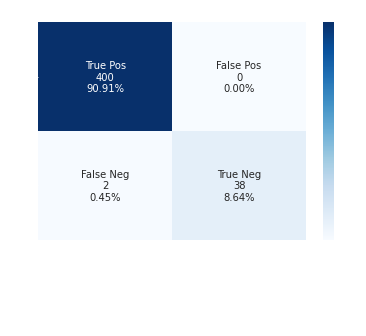

In [32]:
# let's plot the confusion matrix along with statistics
tn, fp, fn, tp = train_conf_mat.ravel()
train_conf_mat1 = np.array([[tp, fp], [fn, tn]])

group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                train_conf_mat1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     train_conf_mat1.flatten()/np.sum(train_conf_mat1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
stats_text = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
                (100 * train_accuracy),
                (100 * train_precision),
                (100 * train_recall),
                (100 * train_f1_score)
                )

ax= plt.subplot()
sns.heatmap(train_conf_mat1, annot=labels, fmt='', ax = ax, cmap='Blues',
            xticklabels = ('NT', 'TP'), yticklabels = ('NT', 'TP'))
ax.set_xlabel('Predicted Labels' + stats_text)
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (Training)')

Text(0.5, 1.0, 'Confusion Matrix (Testing)')

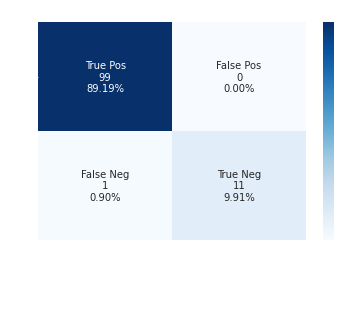

In [33]:
# let's plot the confusion matrix along with statistics
tn, fp, fn, tp = test_conf_mat.ravel()
test_conf_mat1 = np.array([[tp, fp], [fn, tn]])

group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                test_conf_mat1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     test_conf_mat1.flatten()/np.sum(test_conf_mat1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
stats_text = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
                (100 * test_accuracy),
                (100 * test_precision),
                (100 * test_recall),
                (100 * test_f1_score)
                )

ax= plt.subplot()
sns.heatmap(test_conf_mat1, annot=labels, fmt='', ax = ax, cmap='Blues',
            xticklabels = ('NT', 'TP'), yticklabels = ('NT', 'TP'))
ax.set_xlabel('Predicted Labels' + stats_text)
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (Testing)')

In [34]:
# let's get the feature importance

fet_coef_list = []

for i in range(len(scores_dict['estimator'])):
    fet_coef_list.append([scores_dict['estimator'][i].best_estimator_.feature_importances_])

feat_coef = pd.DataFrame(np.concatenate(fet_coef_list), columns = std_mm_X_train.columns)
feat_coef

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
0,1.454145e-03,6.669443e-17,4.396631e-04,0.007769,0.008529,0.028988,2.902768e-04,2.304228e-17,3.010093e-17,0.008221,...,0.007869,0.000536,0.106026,0.051955,0.000938,0.003025,0.001495,0.055327,0.060278,0.021840
1,4.905522e-04,1.032982e-17,0.000000e+00,0.006311,0.010614,0.051037,0.000000e+00,0.000000e+00,0.000000e+00,0.000676,...,0.002699,0.000000,0.123146,0.105717,0.000000,0.002279,0.000000,0.055611,0.118283,0.012533
2,1.034157e-03,4.162943e-18,6.356510e-05,0.004140,0.015696,0.027332,4.407725e-17,5.400964e-17,8.660121e-05,0.003190,...,0.005204,0.000802,0.145669,0.090064,0.001156,0.001537,0.012122,0.046255,0.059092,0.022685
3,1.305964e-03,1.037455e-04,3.613023e-04,0.006819,0.008656,0.026445,1.101830e-04,9.458079e-05,4.823377e-04,0.003814,...,0.005323,0.001043,0.107775,0.077903,0.001304,0.003359,0.010925,0.049738,0.033821,0.016755
4,9.953595e-04,9.629688e-18,1.252514e-04,0.000707,0.005599,0.059257,7.061678e-05,4.611797e-17,1.216821e-04,0.002025,...,0.009312,0.001977,0.094387,0.070562,0.000582,0.003881,0.009305,0.035952,0.108917,0.026741
5,9.488204e-04,3.765700e-17,1.051953e-17,0.002875,0.007591,0.035507,8.822609e-04,8.902909e-17,1.966764e-17,0.002633,...,0.005433,0.000908,0.066969,0.046763,0.000358,0.006689,0.010898,0.036143,0.109347,0.009306
6,8.958053e-18,4.124257e-17,1.439172e-04,0.003147,0.007101,0.045897,1.174711e-17,4.102651e-04,3.607025e-17,0.004131,...,0.008751,0.001807,0.120667,0.062654,0.001574,0.000720,0.007988,0.043080,0.092587,0.014896
7,4.377895e-04,2.605627e-04,3.372907e-04,0.002556,0.013503,0.044731,6.191950e-05,4.819278e-17,6.307354e-05,0.003255,...,0.003807,0.001069,0.093902,0.110535,0.001307,0.002413,0.006244,0.024916,0.078527,0.044428
8,0.000000e+00,0.000000e+00,0.000000e+00,0.001456,0.014748,0.044357,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.003300,0.001931,0.086423,0.069325,0.000000,0.001766,0.013752,0.047325,0.047787,0.014193
9,5.882177e-05,4.379148e-17,2.406235e-04,0.003471,0.015460,0.038356,1.237769e-04,2.462886e-17,2.934119e-04,0.000294,...,0.008877,0.001791,0.103620,0.031184,0.001098,0.001132,0.013542,0.065656,0.079796,0.013858


Text(0, 0.5, 'Random Forest Feature Importance')

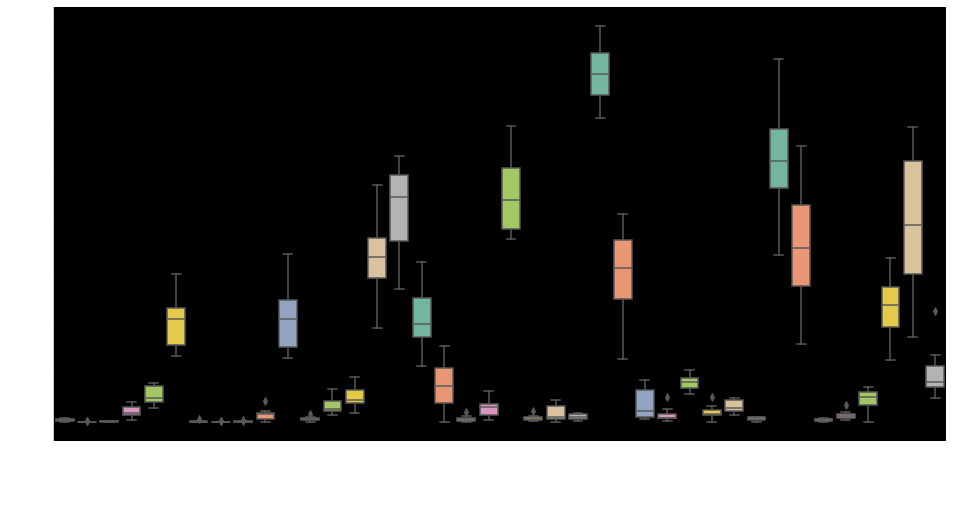

In [35]:
# let's plot the feature importance

fig, ax = plt.subplots(figsize=[16,8])
sns.boxplot(data=feat_coef, palette='Set2')
sns.despine()
plt.xticks(rotation=45, horizontalalignment='right', rotation_mode='anchor', fontweight='light', fontsize='x-large')
plt.ylabel('Random Forest Feature Importance', fontsize=12, weight='bold')

In [36]:
best_n_estimators, best_max_depth = ([], [])

for i in range(len(scores_dict['estimator'])):
    best_n_estimators.append(scores_dict['estimator'][i].best_estimator_.n_estimators)
    best_max_depth.append(scores_dict['estimator'][i].best_estimator_.max_depth)
    rf_best_params = pd.DataFrame({'n_estimators': best_n_estimators, 'max_depth': best_max_depth})

rf_best_params

,n_estimators,max_depth
0,100,6
1,200,2
2,200,3
3,400,5
4,100,5
5,50,5
6,100,4
7,100,6
8,100,2
9,100,4
